In [2]:
from __future__ import print_function

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras import applications
import cv2 
from os import listdir
import numpy as np
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D
from keras.models import Model
import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import tensorflow as tf
import random
import seaborn as sns
import cv2
import os

from pathlib import Path
from keras.utils import to_categorical
from collections import Counter
from plotly.subplots import make_subplots
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.layers.experimental import preprocessing as ps
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
path = Path("G:\\DS\\3.Personal_Projects\\Covid_Classification\\Data")
covid_without_PNEUMONIA_train_path = path / 'train' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_train_path = path / 'train' / 'covid_with_PNEUMONIA'

covid_without_PNEUMONIA_test_path = path / 'test' / 'covid_without_PNEUMONIA'
covid_with_PNEUMONIA_test_path = path / 'test' / 'covid_with_PNEUMONIA'

In [4]:
covid_without_PNEUMONIA_path = [covid_without_PNEUMONIA_train_path, covid_without_PNEUMONIA_test_path]
covid_with_PNEUMONIA_path = [covid_with_PNEUMONIA_train_path, covid_with_PNEUMONIA_test_path]

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [7]:
np.random.seed(42)
random.seed(42)

In [8]:
label2category = {'covid_without_PNEUMONIA': 0, 'covid_with_PNEUMONIA': 1}
category2label = {0: 'covid_without_PNEUMONIA', 1: 'covid_with_PNEUMONIA'}

In [9]:
data = []

for path in covid_without_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_without_PNEUMONIA'})
    
for path in covid_with_PNEUMONIA_path:
    for img in path.glob('*.jpeg'):
        data.append({'img_path': str(img), 'label': 'covid_with_PNEUMONIA'})
        
np.random.shuffle(data)

In [10]:
def counter_label(data=None, key=None, index=None):
    label = []

    for value in data:
        label.append(value[key])

    return Counter(label)

In [15]:
# counter_df = counter_df(data=data, key='label', index='without_augmentation')
img_l_counter = counter_label(data, 'label')
keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

px.bar(x=keys, y=values, color=keys, width=800, height=400)

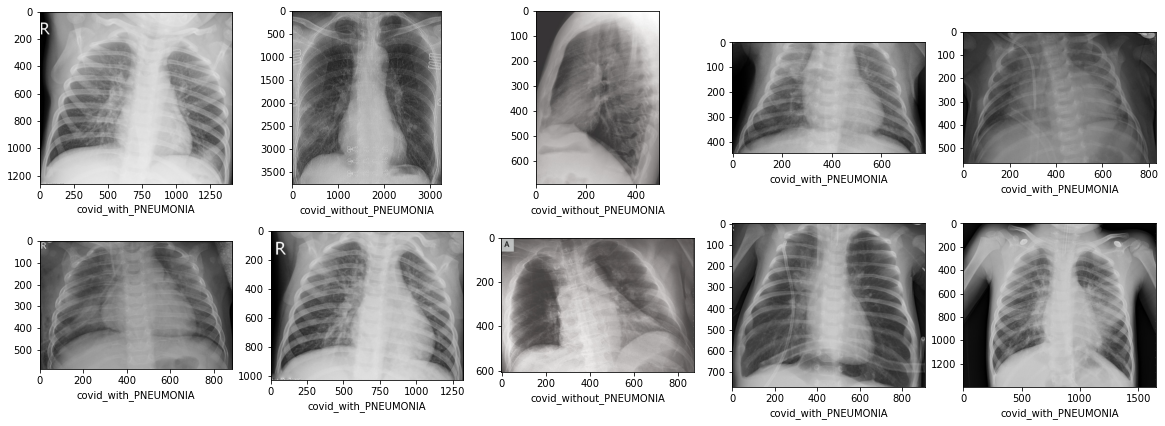

In [12]:
plt.figure(figsize=(20,7))

for i, data_ in enumerate(data[:10]):
    path, label = data_['img_path'], data_['label']
    plt.subplot(2,5,i+1)
    img = cv2.imread(path)
    plt.imshow(img)
    plt.xlabel(label)
    
plt.show()

In [16]:
aug_model = Sequential()
aug_model.add(ps.RandomFlip())

In [17]:
%%time

images_array = []
images_label = []

IMG_SIZE = (64,64)

for data_ in data:
    category = label2category[data_['label']]
    label = to_categorical(category, 2)
    img = cv2.imread(data_['img_path'])

    if category == 0:
        for i in range(2):
            batch = tf.expand_dims(img, 0)
            aug_img = aug_model(batch)
            aug_img = np.array(aug_img[0])
            img = cv2.resize(aug_img, IMG_SIZE)
            img = img / 255
            images_array.append(img)
            images_label.append(label)

    else:

        img = cv2.resize(img, IMG_SIZE)
        img = img / 255
        images_array.append(img)
        images_label.append(label)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Wall time: 16.3 s


In [18]:
images_array = np.array(images_array)
images_label = np.array(images_label)

print('shape of images array: {}'.format(images_array.shape))
print('shape of images label: {}'.format(images_label.shape))

shape of images array: (580, 64, 64, 3)
shape of images label: (580, 2)


In [19]:
def to_labels(labels):
    label_list = []
    for label in labels:
        am = label.argmax()
        label_list.append(category2label[am])
        
    return Counter(label_list)

In [20]:
img_l_counter = to_labels(images_label)
keys = list(img_l_counter.keys())
values = list(img_l_counter.values())

px.bar(x=keys, y=values, color=keys, width=800, height=400)

In [21]:
x_train, x_test, y_train, y_test = train_test_split(images_array, images_label, test_size=0.2, random_state=7)

In [22]:
print('train input shape: {}'.format(x_train.shape))
print('train output shape: {}'.format(y_train.shape))
print('test input shape: {}'.format(x_test.shape))
print('test output shape: {}'.format(y_test.shape))

train input shape: (464, 64, 64, 3)
train output shape: (464, 2)
test input shape: (116, 64, 64, 3)
test output shape: (116, 2)


In [1]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=x_train.shape[1:], activation='relu'))
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(64, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Conv2D(128, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)
model.add(Dropout(0.2))

model.add(Conv2D(512, (3,3), activation='relu'),)
model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'),)

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dropout(0.6))
model.add(Dense(2, activation='softmax'))

NameError: name 'Sequential' is not defined

In [24]:
from numba import cuda
cuda.get_current_device().reset()